<a href="https://colab.research.google.com/github/NethmiJayasinghe/Bidirectional-RNN/blob/main/simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from torch.utils.data import Dataset

class MovingWindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size + 1

    def __getitem__(self, idx):
        window = self.data[idx:idx + self.window_size]
        target = self.data[idx + self.window_size - 1]  # want to predict the last value in the window
        return {'input': window[:-1], 'target': target}


## Sine wave with harmonics dataset

In [ ]:
X_train = np.arange(0,52,0.5)
y_train = np.sin(X_train) + np.sin(3*X_train)/3 + np.sin(5*X_train)/5
n_train = len(X_train)

X_train.resize((n_train,1))

X_test  = np.arange(53,103,0.5)
y_test  = np.sin(X_train) + np.sin(3*X_train)/3 + np.sin(5*X_train)/5
n_test = len(X_test)

X_test.resize((n_test,1))


In [ ]:
X_train.shape

(104, 1)

In [ ]:
y_train.shape

(104,)

In [ ]:
window_size = 16
dataset1 = MovingWindowDataset(y_train, window_size)
n = window_size-1

# Example of accessing data using the dataset
Xtrain = np.empty((0, n))
Ytrain = np.empty((0, 1))

for i in range(len(dataset1)):
    sample = dataset1[i]
    input_window, target = sample['input'], sample['target']
    Xtrain = np.concatenate([Xtrain, input_window.view(1,n)], axis = 0)
    Ytrain = np.concatenate([Ytrain, target.view(1,1)], axis = 0)


Xtest = np.empty((0,n))
Ytest = np.empty((0,1))
dataset2 = MovingWindowDataset(y_test, window_size)
for i in range(len(dataset2)):
    sample = dataset2[i]
    input_window, target = sample['input'], sample['target']
    Xtest = np.concatenate([Xtest, input_window.view(1,n)], axis = 0)
    Ytest = np.concatenate([Ytest, target.view(1,1)], axis = 0)

In [ ]:
Ytrain.shape

(89, 1)

In [ ]:
Xtrain.shape

(89, 15)

## Cardiac wavefrom with noise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_cardiac_waveform(duration, sampling_rate):
    t = np.arange(0, duration, 1/sampling_rate)

    # Simulate a basic cardiac waveform using sine and square waves
    heart_rate = 75  # beats per minute
    cardiac_cycle = np.sin(2 * np.pi * heart_rate / 60 * t) + 0.3 * np.square(np.sin(2 * np.pi * 2 * heart_rate / 60 * t))

    # Add noise to simulate real-world conditions
    noise_amplitude = 0.1
    noise = np.random.normal(0, noise_amplitude, len(t))

    # Combine the cardiac waveform with noise
    cardiac_waveform = cardiac_cycle + noise

    return t, cardiac_waveform

# Set the duration and sampling rate
duration = 10  # seconds
sampling_rate = 50  # samples per second

# Generate the cardiac waveform
time, waveform = generate_cardiac_waveform(duration, sampling_rate)
n_ = 350
total = time.shape[0]
X1_train = time[:n_]
X1_train.resize((n_,1))
y1_train = waveform[:n_]

X1_test = time[n_:]
X1_test.resize((total - n_,1))
y1_test = waveform[n_:]

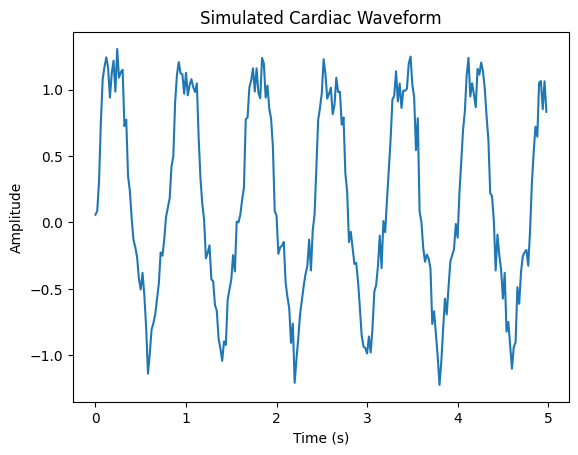

In [ ]:
plt.plot(time[:250], waveform[:250])
plt.title('Simulated Cardiac Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
X1_test.shape

(150, 1)

In [ ]:
window_size = 16
dataset3 = MovingWindowDataset(y1_train, window_size)
n = window_size-1

# Example of accessing data using the dataset
X1train = np.empty((0, n))
Y1train = np.empty((0, 1))

for i in range(len(dataset3)):
    sample = dataset3[i]
    input_window, target = sample['input'], sample['target']
    X1train = np.concatenate([X1train, input_window.view(1,n)], axis = 0)
    Y1train = np.concatenate([Y1train, target.view(1,1)], axis = 0)


X1test = np.empty((0,n))
Y1test = np.empty((0,1))
dataset4 = MovingWindowDataset(y1_test, window_size)
for i in range(len(dataset4)):
    sample = dataset4[i]
    input_window, target = sample['input'], sample['target']
    X1test = np.concatenate([X1test, input_window.view(1,n)], axis = 0)
    Y1test = np.concatenate([Y1test, target.view(1,1)], axis = 0)

In [ ]:
Y1train.shape

(335, 1)

In [ ]:
Y1test.shape

(135, 1)

In [ ]:
X1train.shape

(335, 15)

In [ ]:
# from torch.utils.data import DataLoader, TensorDataset
# Train_Data = TensorDataset(torch.tensor(Xtrain), torch.tensor(Ytrain))
# trainloader = DataLoader(Train_Data, batch_size = 5)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=True)

        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim*2, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # print(r_out.shape)
        # print(hidden.shape)
        # shape output to be (batch_size*seq_length, hidden_dim)
        # r_out = r_out.view(-1, self.hidden_dim)
        # print(r_out.shape)
        # get final output
        output = self.fc(r_out)

        return output, hidden

In [ ]:
# test that dimensions are as expected
test_rnn = RNN(input_size=15, output_size=1, hidden_dim=10, n_layers=1)

test_input = torch.Tensor(X1train).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 335, 15])
Output size:  torch.Size([1, 335, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [ ]:
test_input.shape

torch.Size([1, 335, 15])

In [ ]:
# decide on hyperparameters
input_size=15
output_size=1
hidden_dim=10
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(15, 10, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


In [ ]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [ ]:
# train the RNN
def train(rnn, n_steps, print_every):

    # initialize the hidden state
    hidden = None

    for batch_i, step in enumerate(range(n_steps)):
        # convert data into Tensors
        x_tensor = torch.Tensor(X1train).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(Y1train).unsqueeze(0)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # print(prediction.shape)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:
            print('Loss: ', loss.item())
        #     plt.plot(Ytrain, lw=2) # input
        #     plt.plot(prediction.data.numpy().flatten(), linestyle='--') # predictions
        #     plt.show()

    return rnn

In [ ]:
# train the rnn and monitor results
n_steps = 60
print_every = 5

trained_rnn = train(rnn, n_steps, print_every)

Loss:  0.001257741590961814
Loss:  0.0051579829305410385
Loss:  0.0026279911398887634
Loss:  0.0019239408429712057
Loss:  0.0018522385507822037
Loss:  0.001953110913746059
Loss:  0.0017892835894599557
Loss:  0.0015236790059134364
Loss:  0.0013235079823061824
Loss:  0.0011833258904516697
Loss:  0.0010482625802978873
Loss:  0.0009522346663288772


In [ ]:
# Testing
def test(rnn, Xtest):
  hidden = None
  x_tensor = torch.Tensor(Xtest).unsqueeze(0)
  prediction, hidden = rnn(x_tensor, hidden)
  return prediction

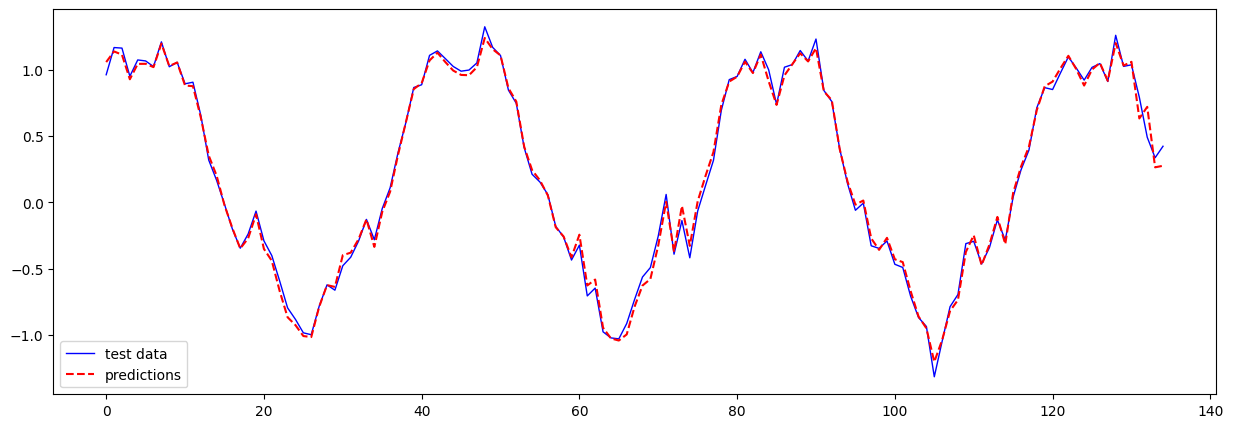

In [ ]:
test_predictions  = test(trained_rnn, X1test).detach().numpy().squeeze(0)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(Ytrain, lw=3,c='y', label='train data')
ax.plot(Y1test, lw=1, c='b', label='test data')
ax.plot(test_predictions, linestyle='--', c='r', label='predictions')
ax.legend(loc="lower left")
plt.show();